One interesting aspect of the Sun is its sunspots. Sunspots are areas where the magnetic field is about 2,500 times stronger than Earth's, much higher than anywhere else on the Sun. Because of the strong magnetic field, the magnetic pressure increases while the surrounding atmospheric pressure decreases. This in turn lowers the temperature relative to its surroundings because the concentrated magnetic field inhibits the flow of hot, new gas from the Sun's interior to the surface.

Sunspots tend to occur in pairs that have magnetic fields pointing in opposite directions. A typical spot consists of a dark region called the umbra, surrounded by a lighter region known as the penumbra. The sunspots appear relatively dark because the surrounding surface of the Sun (the photosphere) is about 10,000 degrees F., while the umbra is about 6,300 degrees F. Sunspots are quite large as an average size is about the same size as the Earth.

Sunspots increase and decrease, then again increases and decreases through an average cycle of 11 years. Solar cycle 1 was the first solar cycle since extensive recording of solar sunspot activity began in 1755 and we have experienced a total of 24 full solar cycles since then. Currently, we are in 25th solar cycle, the solar cycle 25 began in December 2019 and is expected to last till more 11 years that is about 2030.

#Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Data Science Portfolio/Sunspots Prediction-LSTM Model/

/content/drive/MyDrive/Data Science Portfolio/Sunspots Prediction-LSTM Model


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Lambda, LSTM, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import warnings
warnings.filterwarnings("ignore")

#Load Data

In [4]:
# link for dataset : https://www.kaggle.com/datasets/robervalt/sunspots
df = pd.read_csv("Sunspots.csv")
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [5]:
df.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8
3264,3264,2021-01-31,10.4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.6+ KB


In [7]:
sunspots = df.iloc[:,-1]

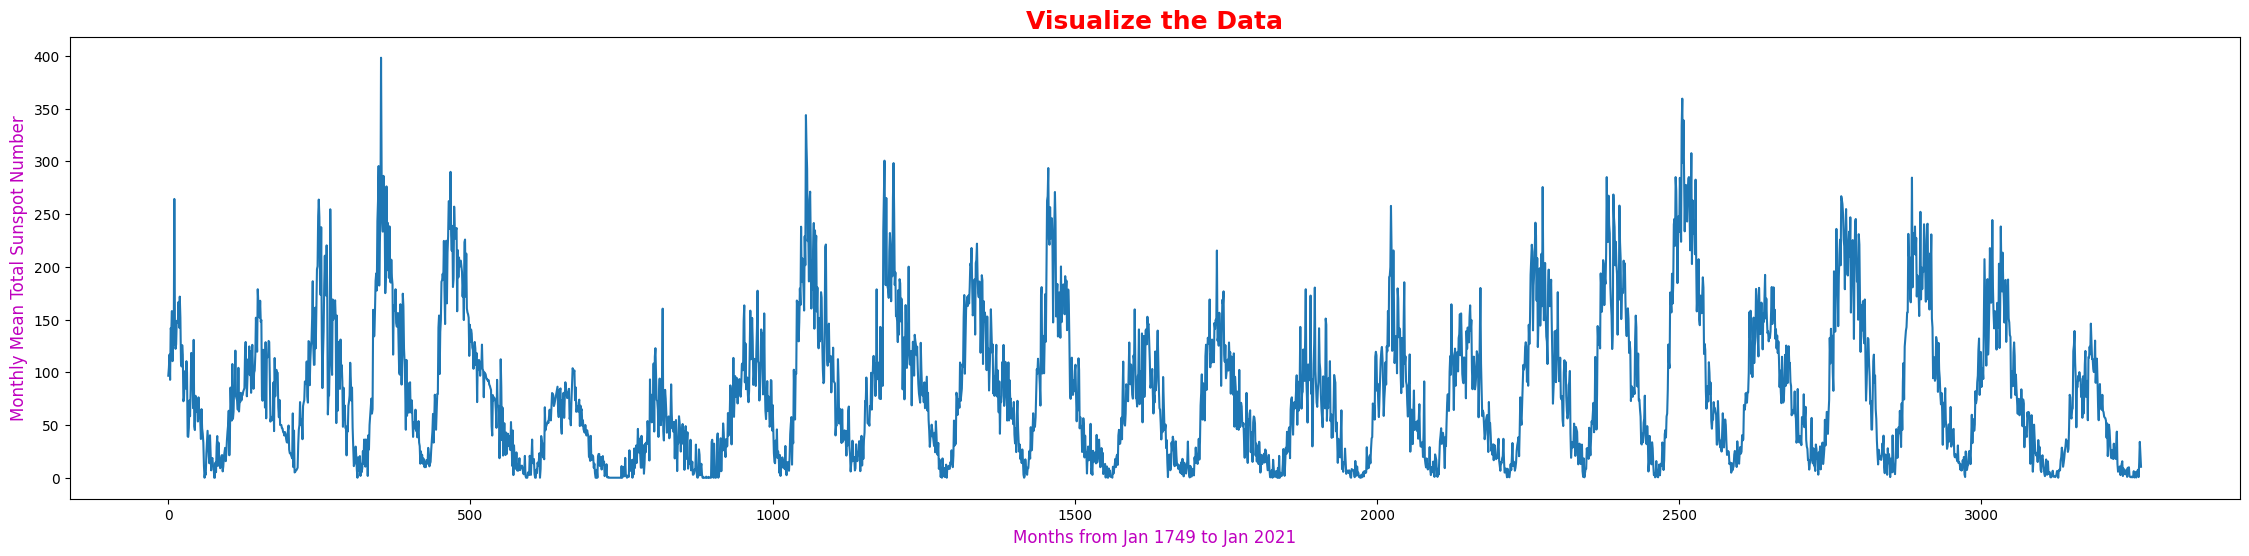

In [8]:
# Plot the sunspots data
plt.figure(figsize=(28,6))
plt.plot(sunspots)
plt.title("Visualize the Data", fontsize = 18, color = 'r', weight = 'bold')
plt.xlabel("Months from Jan 1749 to Jan 2021", fontsize = 12, color = 'm')
plt.ylabel(df.columns[-1], fontsize = 12, color = 'm')
plt.show()


    The first solar cycle started from 1755 but our sunspots data starts from 1749. That's a total of 6 years which means 72 months of data
    Hence, we can see the initial part of the graph decreasing to minimum till the first 72 months
    Each solar cycle lasts approx 11 years, that is about 132 months
    The current cycle is the solar cycle 25 which began in December 2019 but our data is till January 2021. That's about 13 months of data from the current cycle


In [9]:
sunspots

0        96.7
1       104.3
2       116.7
3        92.8
4       141.7
        ...  
3260      0.6
3261     14.4
3262     34.0
3263     21.8
3264     10.4
Name: Monthly Mean Total Sunspot Number, Length: 3265, dtype: float64

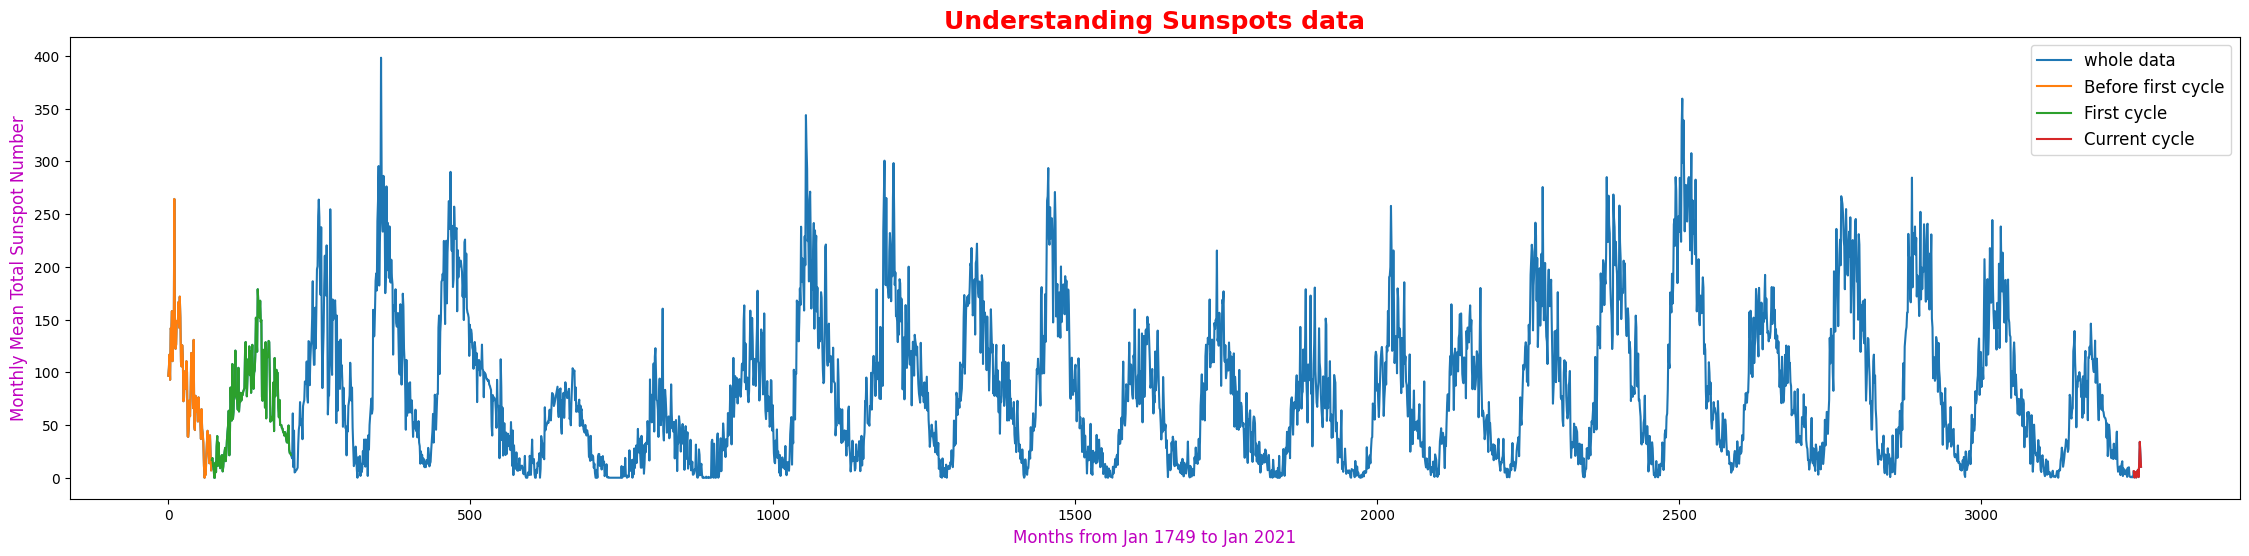

In [10]:
# Plot different segments of sunspots data to understand solar cycles
plt.figure(figsize=(28,6))
plt.plot(sunspots)            # The whole data
plt.plot(sunspots[:72])       # Data starting from 1749 with actual cycles starting from 1755, indicates a span of six years, equivalent to 72 months
plt.plot(sunspots[72:72+132]) # showing first solar cycle
plt.plot(sunspots[-13:])      # current cycle
plt.title("Understanding Sunspots data", fontsize = 18, weight = 'bold', color = 'r')
plt.xlabel("Months from Jan 1749 to Jan 2021", fontsize = 12, color = 'm')
plt.ylabel(df.columns[-1], fontsize = 12, color = 'm')
plt.legend(["whole data","Before first cycle","First cycle","Current cycle"], fontsize = 12)

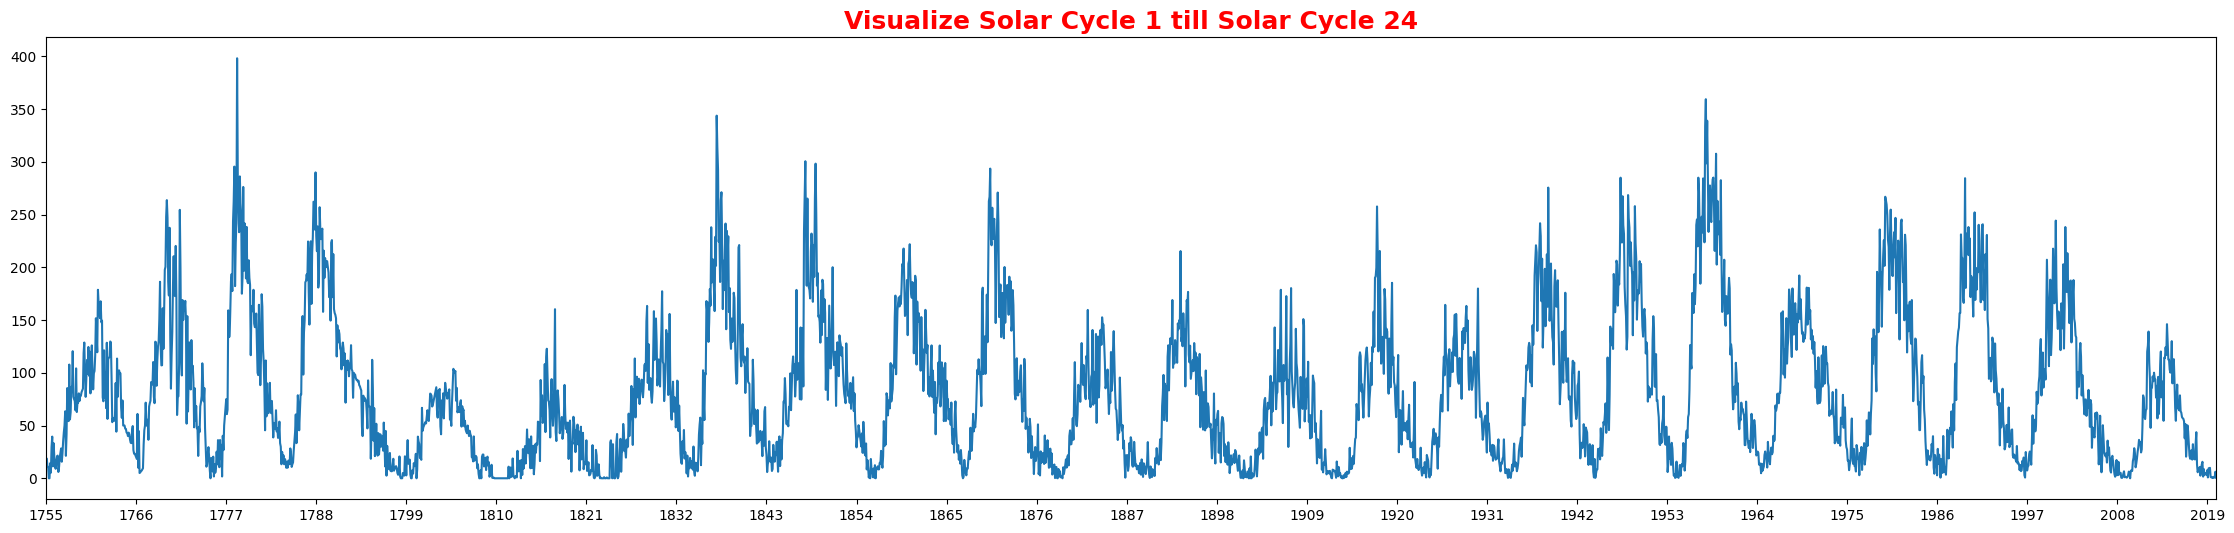

In [11]:
# Visualize Solar Cycle 1 till Solar Cycle 24, Plot sunspots data for each solar cycle
years = []
start = 1755
for i in range(0, len(df.iloc[:,-1][72:]),132):
    years.append(start)
    start+=11

plt.figure(figsize = (28, 6))
plt.plot(sunspots[72:])
plt.title("Visualize Solar Cycle 1 till Solar Cycle 24", weight = 'bold', color = 'r', fontsize = 18)
plt.xlim(72, 3265-12)
plt.xticks(range(72, len(sunspots),132))
plt.gca().set_xticklabels(years)
plt.show()

In [12]:
sunspots.values

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

In [13]:
# Windowed Dataset Creation
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[:, np.newaxis]                 # Convert series to a 2D array with one additional axis
    ds = tf.data.Dataset.from_tensor_slices(series)   # Create a TensorFlow dataset from the series
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # Window the dataset with the specified window size, shift, and drop remainder
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))          # Flatten the windows into batches
    ds = ds.shuffle(shuffle_buffer)                               # Shuffle the dataset to reduce overfitting
    ds = ds.map(lambda w: (w[:-1], w[-1]))                        # Map each window to (input features, target output) tuple
    return ds.batch(batch_size).prefetch(1)                       # Batch the dataset and prefetch one batch for training

In [14]:
# Model Forecasting
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

#Build Model

In [15]:
# Prepare data
series = df['Monthly Mean Total Sunspot Number'].values
time = df['Unnamed: 0'].values

In [16]:
# Split data into train and validation sets
split_time = int(len(series) * 0.9)          # 90% of the original data is for training
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(f"There are {len(x_train)} training samples and {len(x_valid)} validation samples.")

There are 2938 training samples and 327 validation samples.


In [17]:
# Define model parameters
delta = 1                      # huber loss
window_size = 60               # for dataset
batch_size = 145               # for dataset
shuffle_buffer_size= 900       # shuffling the dataset randomly
epochs = 100                   # for optimal learning rate
train_epochs = epochs + 100    # training epochs
momentum_sgd = 0.9             # for optimizer

In [18]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create windowed dataset for training
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build LSTM model for sunspot prediction
X_input = layers.Input(shape=[None, 1])
X = Conv1D(filters = 132, kernel_size = 4, padding = "causal", activation = "relu")(X_input)
X = LSTM(256, return_sequences = True)(X)
X = LSTM(132, return_sequences = False)(X)
X = Dense(80, activation = "relu")(X)
X = Dense(10, activation = "relu")(X)
X = Dense(1)(X)
X = Lambda(lambda x: x * 400)(X)

model = Model(inputs = X_input, outputs = X)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 132)         660       
                                                                 
 lstm (LSTM)                 (None, None, 256)         398336    
                                                                 
 lstm_1 (LSTM)               (None, 132)               205392    
                                                                 
 dense (Dense)               (None, 80)                10640     
                                                                 
 dense_1 (Dense)             (None, 10)                810       
                                                                 
 dense_2 (Dense)             (None, 1)                 11    

In [19]:
# Define learning rate scheduler
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20)) # lr --> starting lr * 10^(0/20), starting lr * 10^(1/20), so on..

# Compile the model with stochastic gradient descent optimizer
optimizer = SGD(learning_rate = 1e-8, momentum = momentum_sgd)
model.compile(loss = tf.keras.losses.Huber(delta), optimizer = optimizer, metrics = ["mae"])

In [20]:
# Train the model and track history
history = model.fit(train_set, epochs = epochs, callbacks = [lr_schedule])

Epoch 1/100
20/20 [==============================] - 24s 912ms/step - loss: 122.4669 - mae: 122.9667 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 18s 898ms/step - loss: 90.4130 - mae: 90.9126 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 18s 898ms/step - loss: 80.9368 - mae: 81.4353 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 18s 894ms/step - loss: 73.4880 - mae: 73.9855 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 20s 953ms/step - loss: 67.0173 - mae: 67.5143 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 18s 896ms/step - loss: 61.7019 - mae: 62.1995 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 19s 965ms/step - loss: 57.5226 - mae: 58.0197 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 18s 891ms/step - loss: 54.1694 - mae: 54.6672 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 19s 941ms/step - 

In [21]:
# learning rates used above
lrs = 1e-8 * (10**(np.arange(epochs)/20))
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [22]:
# fetch the optimum learning rate
min_loss = min(history.history['loss'])
opt_idx = np.argmin(history.history['loss'])  # find the index of the minimum loss
opt_lr = lrs[opt_idx]                         # get the corresponding learning rate
print(f"Optimal Learning Rate was --> {opt_lr}.")


Optimal Learning Rate was --> 5.011872336272725e-06.


In [23]:
min_loss

17.37688446044922

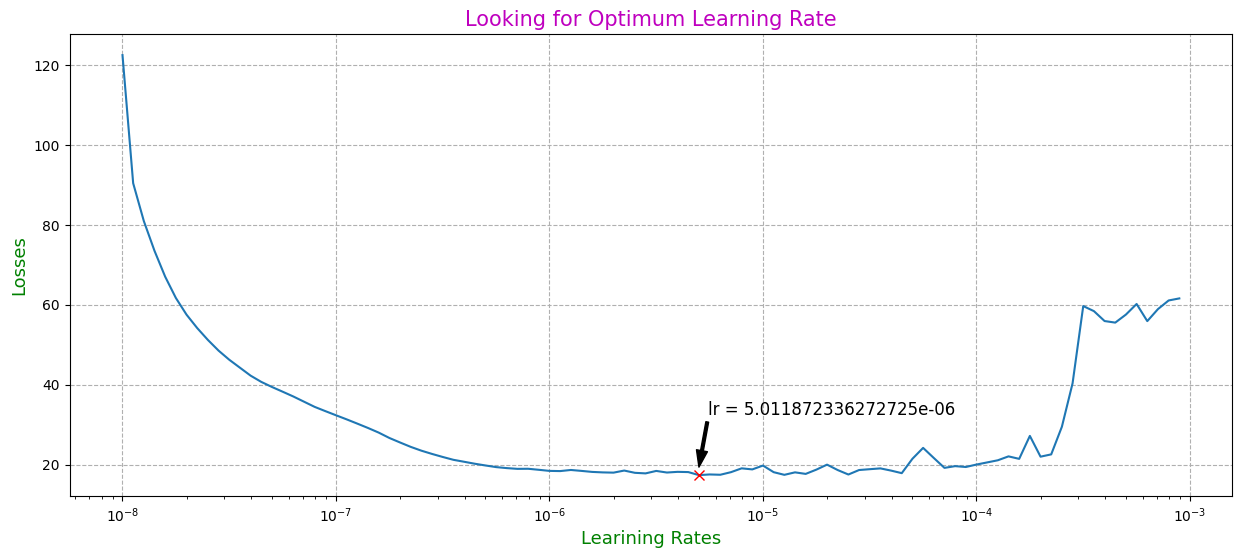

In [24]:
# Plot losses vs. learning rates to find optimal learning rate
fig = plt.figure(figsize=(15, 6))
plt.semilogx(lrs, history.history["loss"]) # learning rates are increasing exponentially and hence for an omptimal sized plot we use semilogx plot
plt.grid(True, ls="--")
plt.plot(opt_lr, min_loss, color = 'r', marker = 'x', markersize = 7)
plt.title(f"Looking for Optimum Learning Rate", color = 'm', fontsize = 15)
plt.ylabel("Losses", fontsize = 13, color = 'g')
plt.xlabel("Learining Rates", fontsize = 13, color = 'g')
plt.annotate(f"lr = {opt_lr}", (opt_lr, min_loss+2), (opt_lr+0.05e-5, min_loss+15), arrowprops = dict(facecolor ='k', width = 2, headwidth = 8), fontsize = 12)
plt.show()

In [25]:
# Rebuild the model with optimal learning rate
tf.random.set_seed(42)
np.random.seed(42)

X_input = layers.Input(shape=[None, 1])
X = Conv1D(filters = 132, kernel_size = 4, padding = "causal", activation = "relu")(X_input)
X = LSTM(256, return_sequences = True)(X)
X = LSTM(132, return_sequences = False)(X)
X = Dense(80, activation = "relu")(X)
X = Dense(10, activation = "relu")(X)
X = Dense(1)(X)
X = Lambda(lambda x: x * 400)(X)

model = Model(inputs = X_input, outputs = X)

In [26]:
optimizer = tf.keras.optimizers.SGD(learning_rate = opt_lr, momentum = momentum_sgd)
model.compile(loss = tf.keras.losses.Huber(delta), optimizer = optimizer, metrics = ["mae"])

In [27]:
# Train the model with optimal learning rate
history = model.fit(train_set, epochs = train_epochs)

Epoch 1/200
20/20 [==============================] - 24s 911ms/step - loss: 31.0332 - mae: 31.5284
Epoch 2/200
20/20 [==============================] - 18s 907ms/step - loss: 19.7978 - mae: 20.2896
Epoch 3/200
20/20 [==============================] - 19s 914ms/step - loss: 19.0190 - mae: 19.5125
Epoch 4/200
20/20 [==============================] - 18s 913ms/step - loss: 20.8728 - mae: 21.3656
Epoch 5/200
20/20 [==============================] - 20s 934ms/step - loss: 21.8237 - mae: 22.3175
Epoch 6/200
20/20 [==============================] - 19s 926ms/step - loss: 18.8623 - mae: 19.3550
Epoch 7/200
20/20 [==============================] - 21s 997ms/step - loss: 18.0390 - mae: 18.5311
Epoch 8/200
20/20 [==============================] - 20s 945ms/step - loss: 19.0744 - mae: 19.5681
Epoch 9/200
20/20 [==============================] - 18s 915ms/step - loss: 18.1840 - mae: 18.6775
Epoch 10/200
20/20 [==============================] - 19s 965ms/step - loss: 18.5467 - mae: 19.0403
Epoch 11/

#Evaluate Model

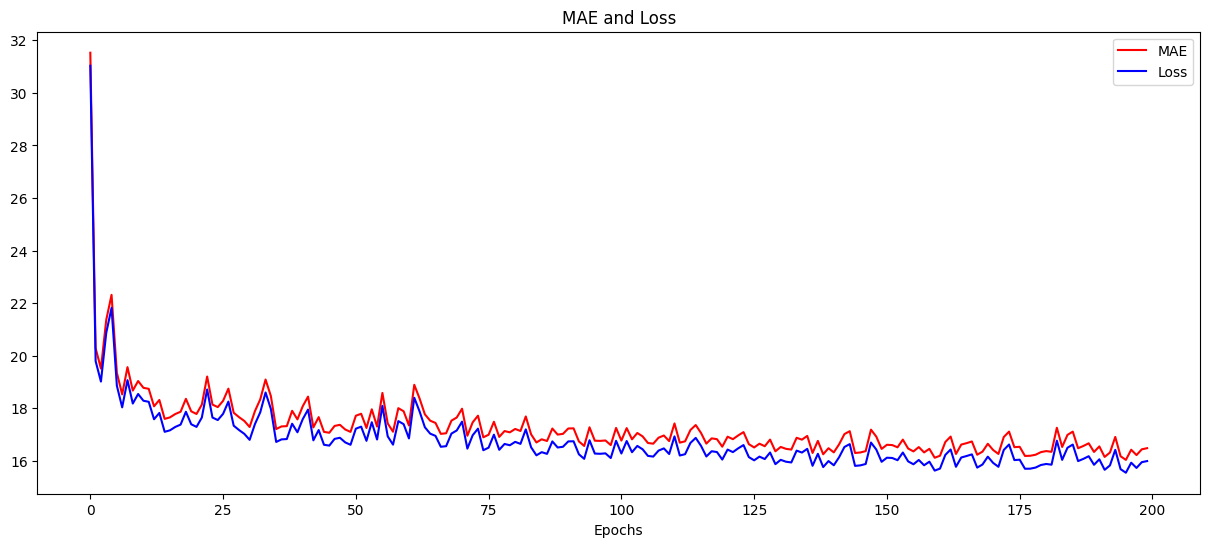

In [28]:
# Fetch the Mean Absolute Error (MAE) and Huber loss from the training history
mae = history.history['mae']
loss = history.history['loss']

# Plot the Mean Absolute Error (MAE) and Huber loss over epochs
fig = plt.figure(figsize=(15, 6))
plt.plot(mae, 'r')
plt.plot(loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.legend(["MAE", "Loss"])

23/23 [==============================] - 7s 280ms/step


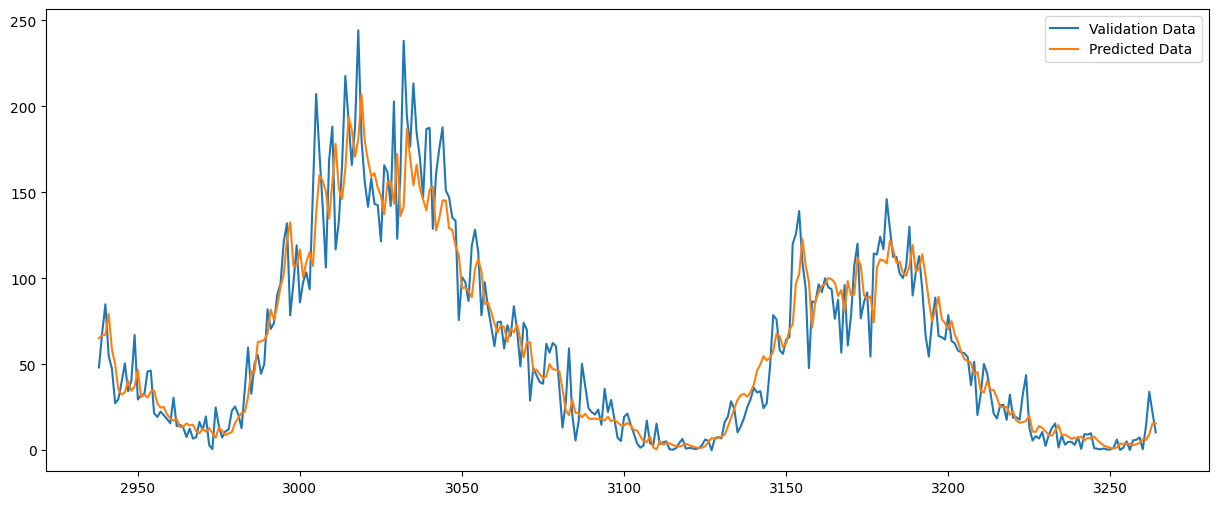

In [29]:
# Generate model forecast and plot validation data against predicted data
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]  # rnn_forecast[-328:-1, 0]

# Plot the validation data and predicted data
plt.figure(figsize=(15, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.title("")
plt.legend(["Validation Data", "Predicted Data"])
plt.show()

In [30]:
# Calculate and display Mean Absolute Error (MAE) on the validation data
val_mae = tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
print(f"MAE on the validation data:- {val_mae}")

MAE on the validation data:- 12.457146644592285
